In [14]:
from raytracing.interaction import Edge, Surface
from raytracing.plotting import new_3d_axes
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np

In [15]:
filename = "broadway_simu.pickle"

with open(filename, 'rb') as f:
    simu = pickle.load(f)

<IPython.core.display.Javascript object>


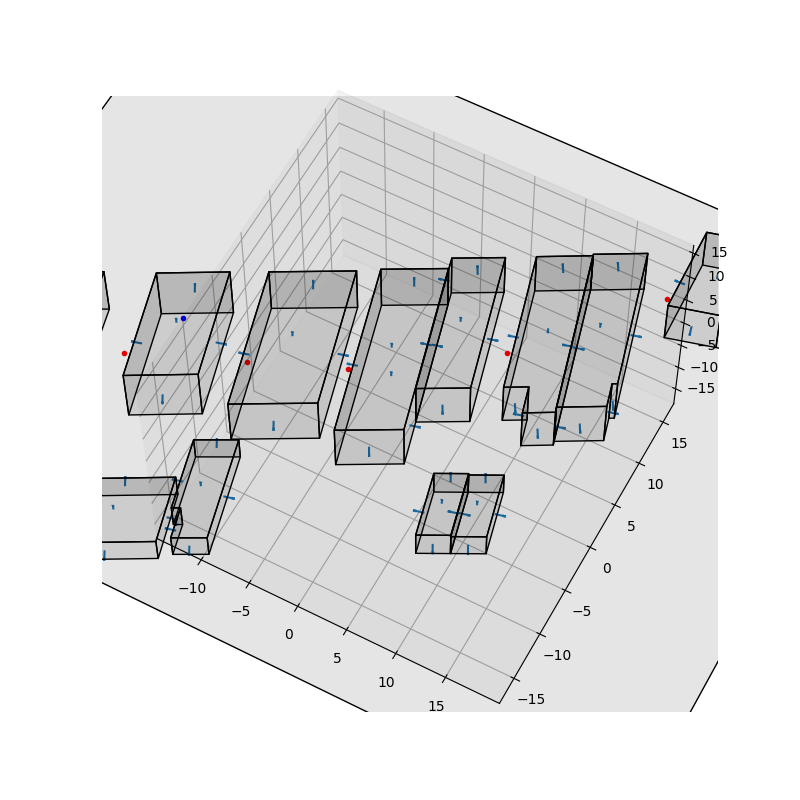

In [27]:
%matplotlib notebook

ax = new_3d_axes(figsize=(8, 8))

paths = simu.paths

show = None

if isinstance(show, int):
    simu.paths = {show: simu.paths[show]}
elif show is None:
    simu.paths = {}
    
simu.on(ax).plot()
    
simu.paths = paths


In [4]:
paths = simu.paths

def length(path):
    return np.linalg.norm(path.points, axis=1).sum()

def path_los_fs_db(path):
    c = 3e8
    d = length(path)
    f = 26e9
    fspl = (4*np.pi*d*f/c)
    
    return 20 * np.log10(fspl)

def path_los_diff_db(path):
    
    loss = 0
    
    def _loss(angle):
        
        angle = np.rad2deg(angle)
        
        """
        if angle < 5:
            return 5 * np.log(angle) + 18
        else:
            return 0.74 * angle + 25
        """
        #return 0.96 * angle + 6.03
        return 0.5702 * 28 + 0.9078 * angle - 4.9056
    
    for i, interaction in enumerate(path.interact_list):
        if isinstance(interaction, Edge):
            v_in, v_out = np.diff(path.points[i:i+3, :], axis=0)
            cos = np.dot(v_in, v_out) / (np.linalg.norm(v_in) * np.linalg.norm(v_out))
            angle = np.arccos(cos)
            
            loss += _loss(angle)
            
    return loss

def path_loss_db(path):
    return path_los_diff_db(path) + path_los_fs_db(path)

def n_refl(path):
    return sum(1 for interaction in path.interact_list if isinstance(interaction, Surface))

def n_diff(path):
    return sum(1 for interaction in path.interact_list if isinstance(interaction, Edge))

def diff_indices(path):
    return format(sum((1 << i ) * isinstance(interaction, Edge) for i, interaction in enumerate(path.interact_list)), f'0{len(path) - 2}b')

data = [(receiver, length(path), len(path) - 2, diff_indices(path), path_loss_db(path)) for receiver, paths in paths.items() for path in paths]

In [5]:

df = pd.DataFrame(data, columns=("receiver", "length", "n_interact", "diff_indices", "path_loss"))

df.groupby(["receiver", "n_interact", "diff_indices"]).describe(percentiles=[])

length                                     \
                                  count        mean        std         min   
receiver n_interact diff_indices                                             
0        1          1               2.0   70.053655   2.992334   67.937756   
         2          01              2.0   94.588311   0.401210   94.304613   
                    11             10.0   93.671420   4.454559   85.804430   
         3          001             2.0  119.311362   3.043400  117.159353   
                    011            15.0  117.841770   6.048353  107.314406   
                    101             8.0  116.388613   7.819908  102.309395   
                    110             3.0  123.282023   0.091569  123.184591   
                    111            51.0  114.028223  10.100669   92.280159   
1        1          1               1.0   88.437936        NaN   88.437936   
         2          01              1.0  123.177471        NaN  123.177471   
                    11              2.0  112.756345  14.876971  102.236738   
         3          011             2.0  146.857058  13.504382  137.308018   
                    111             5.0  126.757076  10.174180  115.199873   
2        1          1               2.0   49.861362   2.224623   48.288315   
         2          01              2.0   64.253634   0.290177   64.048448   
                    11             14.0   68.643772   6.245287   60.039474   
         3          001             2.0   79.229114   2.981939   77.120564   
                    011            12.0   80.932467   4.408600   72.649179   
                    100             1.0   78.030677        NaN   78.030677   
                    101             7.0   86.884809  11.489131   78.584147   
                    110             3.0   89.906048  10.362088   83.104110   
                    111            75.0   91.254115  11.124416   69.596060   
3        1          1               2.0   33.628760   0.664071   33.159191   
         2          01              2.0   38.960076   0.183669   38.830202   
                    11             10.0   49.922111   7.580634   42.470975   
         3          001             2.0   45.034863   0.901512   44.397397   
                    011            10.0   54.814737   7.139308   47.199773   
                    101             3.0   54.450413   1.747829   53.182503   
                    111            49.0   74.010405  14.549799   54.207655   
4        1          1               2.0   43.297429   1.429062   42.286930   
         2          01              3.0   54.001918   0.571277   53.609046   
                    11             13.0   65.264101  12.849820   52.833435   
         3          001             2.0   64.307290   1.401869   63.316019   
                    011            18.0   73.522421  12.330727   62.110344   
                    101            12.0   74.895059   9.468110   65.715075   
                    111            89.0   83.562164  14.998054   63.705699   
5        1          1               1.0   70.296709        NaN   70.296709   
         2          11              4.0  100.272472   6.369506   94.504957   
         3          011             1.0  117.943622        NaN  117.943622   
                    101             3.0  127.844363  18.323357  107.774983   
                    111            24.0  125.833526   9.866076  108.100643   
6        2          01              1.0  130.164156        NaN  130.164156   
                    10              1.0  128.322834        NaN  128.322834   
                    11              5.0  122.091831   8.637190  110.269523   
         3          001             1.0  166.226159        NaN  166.226159   
                    010             1.0  162.490901        NaN  162.490901   
                    011            11.0  153.282238  11.179104  138.820279   
                    101             6.0  148.466046  16.023008  118.856259   
                    110             1.0  169.883968    

In [6]:
df.drop(["receiver", "length"], axis=1).groupby(["n_interact", "diff_indices"]).describe(percentiles=[])

path_loss                                     \
                            count        mean        std         min   
n_interact diff_indices                                                
1          1                 11.0  174.037925  15.374640  145.845491   
2          01                12.0  183.509490  31.018085  134.433283   
           10                 1.0  186.924524        NaN  186.924524   
           11                66.0  290.455621  66.198072  182.362282   
3          001                9.0  182.267760  47.985961  122.136745   
           010                1.0  186.809153        NaN  186.809153   
           011               78.0  297.651314  66.536608  151.615063   
           100                1.0  210.365705        NaN  210.365705   
           101               43.0  291.176664  67.448155  183.628818   
           110                9.0  311.088734  52.625790  226.919504   
           111              365.0  413.646399  73.586544  203.883475   

                                                 
                                50%         max  
n_interact diff_indices                          
1          1             172.055378  201.209359  
2          01            193.512553  221.956388  
           10            186.924524  186.924524  
           11            304.492130  391.869979  
3          001           213.939884  240.164931  
           010           186.809153  186.809153  
           011           304.264132  414.893249  
           100           210.365705  210.365705  
           101           315.958991  386.282202  
           110           315.819834  379.459733  
           111           401.372441  543.948564